In [1]:
# This script demonstrates the capabilities of cluster_slug by using
# it to re-analyze the M31 star clusters catalog of Johnson et al. (2015, ApJ)

# Import the libraries we'll need
from astropy.io import ascii
from astropy.io import fits
import emcee
from astropy import table
from astropy.table import unique, Table, hstack, Column
import sys
from numpy import inf
import numpy as np
import numpy.ma as ma
import time
from matplotlib.pyplot import figure as fig
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from scipy.stats import norm
from slugpy.cluster_slug import cluster_slug
from slugpy import * 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator

In [2]:
#Imported AP fits files which include best fit of mass and age data already 

apdata = Table.read('apdata-cluster_6phot+agemass.fits')
print("Reading AP Cluster Data (Phot+Agemasss)...")
apdata_12clusters = Table.read('apdata-cluster_6phot+agemass_select.fits')
print("Reading AP 12 Cluster Data (Phot+AgeMass)...")

apdata_good_phot6filts=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Photometery_Tables/apdata_goodphot_6filts.fits')
apdatagoodphot_2filts=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Photometery_Tables/apdata_goodphot_2filts_Only475_814.fits')

#SLUG Model Library of photometry and property values
LEGUS_PHAT_PadKroupa_prop=Table.read('LEGUS_1e6_1e10age_PadKroupaAfter_PHAT_lib_1e7Trials_cluster_prop.fits')
LEGUS_PHAT_PadKroupa_phot=Table.read('LEGUS_1e6_1e10age_PadKroupaAfter_PHAT_lib_1e7Trials_cluster_phot.fits')

m31_Prop6filt=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Prop_Tables/m31_Prop6filt.fits')

dmod_M31=24.47 

Reading AP Cluster Data (Phot+Agemasss)...
Reading AP 12 Cluster Data (Phot+AgeMass)...


In [23]:
M31_Chi2Vals6=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/ClusterChi_Square_Values/M31_ClsChi2Vals6filt.fits')
M31_Chi2Vals5=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/ClusterChi_Square_Values/M31_ClsChi2Vals5filt.fits')
M31_Chi2Vals4=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/ClusterChi_Square_Values/M31_ClsChi2Vals4filt.fits')
M31_Chi2Vals2=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/ClusterChi_Square_Values/M31_ClsChi2Vals2filt.fits')


In [4]:
m31_Prop6filt=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Prop_Tables/m31_Prop6filt.fits')
m31_Prop5filt=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Prop_Tables/M31_Prop5filt891cls.fits')
m31_Prop4filt=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Prop_Tables/M31_Prop4filt1197cls.fits')
#m31_Prop2filt=Table.read('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Prop_Tables/M31_Prop2filt.fits')

In [26]:
m31_prop_all=hstack([m31_Prop6filt,m31_Prop5filt,m31_Prop4filt,m31_Prop2filt])
m31_prop_all

ID_1,BEST_METHOD_1,Chi_2(6),Mass_PDF_P25(6),Mass_PDF_Median(6),Mass_PDF_P75(6),MassIQR(6),SlugMass-m31BestMass(6),Age_PDF_P25(6),Age_PDF_Median(6),Age_PDF_P75(6),AgeIQR(6),SlugAge-m31BestAge(6),AV_PDF_P25(6),A_V_PDF_Median(6),A_V_PDF_P75(6),AvIQR(6),SlugAV-CMD_AV_Best(6),ID_2,BEST_METHOD_2,Chi_2(5),Mass_PDF_P25(5),Mass_PDF_Median(5),Mass_PDF_P75(5),MassIQR(5),SlugMass-m31BestMass(5),Age_PDF_P25(5),Age_PDF_Median(5),Age_PDF_P75(5),AgeIQR(5),SlugAge-m31BestAge(5),AV_PDF_P25(5),A_V_PDF_Median(5),A_V_PDF_P75(5),AvIQR(5),SlugAV-CMD_AV_Best(5),ID_3,BEST_METHOD_3,Chi_2(4),Mass_PDF_P25(4),Mass_PDF_Median(4),Mass_PDF_P75(4),MassIQR(4),SlugMass-m31BestMass(4),Age_PDF_P25(4),Age_PDF_Median(4),Age_PDF_P75(4),AgeIQR(4),SlugAge-m31BestAge(4),AV_PDF_P25(4),A_V_PDF_Median(4),A_V_PDF_P75(4),AvIQR(4),SlugAV-CMD_AV_Best(4),ID_4,BEST_METHOD_4,Chi_2(2),Mass_PDF_P25(2),Mass_PDF_Median(2),Mass_PDF_P75(2),MassIQR(2),SlugMass-m31BestMass(2),Age_PDF_P25(2),Age_PDF_Median(2),Age_PDF_P75(2),AgeIQR(2),SlugAge-m31BestAge(2),AV_PDF_P25(2),A_V_PDF_Median(2),A_V_PDF_P75(2),AvIQR(2),SlugAV-CMD_AV_Best(2)
int32,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,I,2.7985711649757494,2.307080791931832,4.220375004918627,4.480205083225476,2.173124291293644,-0.08965105167155674,7.07086623612586,8.67716512372204,8.960629633297836,1.8897633971719765,0.29379263232044117,0.26388315860375433,0.6098587952263942,1.6477857050943139,1.3839025464905594,-0.6098587952263942,1,I,0.3194347026193026,2.354322624351259,4.0550285914506325,4.432963250806049,2.07864062645479,0.07569536179643777,7.07086623612586,8.393700614146244,8.929133576678304,1.8582673405524437,0.5772571418962364,0.26388315860375433,0.6592838861724857,1.7466358869864964,1.4827527283827422,-0.6592838861724857,1,I,2.5684339984198012,2.401564456770686,4.267616837338054,4.527446915644903,2.125882458874217,-0.136892884090984,7.1338583493649255,8.708661180341572,8.99212568991737,1.8582673405524437,0.26229657570090836,0.26388315860375433,0.6098587952263942,1.548935523202131,1.2850523645983767,-0.6098587952263942,1,I,1.3330784569926594e-05,2.1889762108832644,2.732257283706675,4.149512256289487,1.9605360454062226,1.3984666695403951,6.094488480920338,6.440945103735201,8.551180897243908,2.4566924163235697,2.5300126523072795,0.46158352238812,1.1535347956333997,1.9443362507708621,1.4827527283827422,-1.1535347956333997
4,I,2.1949285655453195,2.2834598757221185,4.196754088708913,4.432963250806049,2.1495033750839303,-0.07106935054973373,7.07086623612586,8.645669067102506,8.960629633297836,1.8897633971719765,0.3290108797969076,0.21445806765766293,0.6098587952263942,1.6477857050943139,1.433327637436651,-0.6098587952263942,4,I,0.22185885679230938,2.3779435405609726,3.9605449266117785,4.362100502176908,1.9841569616159354,0.1651398115474012,7.039370179506327,8.299212444287644,8.866141463439238,1.8267712839329109,0.6754675026117702,0.26388315860375433,0.6592838861724857,1.7466358869864964,1.4827527283827422,-0.6592838861724857,4,I,1.8311898052344433,2.354322624351259,4.243995921128341,4.50382599943519,2.1495033750839307,-0.11831118296916099,7.1338583493649255,8.67716512372204,8.99212568991737,1.8582673405524437,0.29751482317737477,0.21445806765766293,0.5604337042803027,1.548935523202131,1.334477455544468,-0.5604337042803027,4,I,0.00017348730626736097,2.165355294673551,2.637773618867821,3.8660612617729244,1.7007059670993736,1.4879111192913586,6.094488480920338,6.409449047115668,8.173228217809513,2.0787397368891742,2.565230899783746,0.4615

In [27]:
m31_prop_all.remove_columns(['ID_2','BEST_METHOD_2','ID_3','BEST_METHOD_3','ID_4','BEST_METHOD_4'])


In [28]:
m31_prop_all.write('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Prop_Tables/M31_Prop_All.fits')

In [5]:
#Extract photometry from the AP PHAT catalog and pack it into arrays
cluster_id = np.array(apdatagoodphot_2filts['ID'])

#F275W filter with error
#apdata_good_phot6filts['MAG275'][apdata_good_phot6filts['MAG275'] == 'INDEF'] = -99
#m275 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG275'], dtype='float64'), -99) - dmod_M31
#apdata_good_phot6filts['SIG275'][apdata_good_phot6filts['SIG275'] == 'INDEF'] = -99
#m275err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG275'], 
#                                   dtype='float64'), -99)

#F336W filter with error
#apdata_good_phot6filts['MAG336'][apdata_good_phot6filts['MAG336'] == 'INDEF'] = -99
#m336 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG336'], dtype='float64'), -99) - dmod_M31
#apdata_good_phot6filts['SIG336'][apdata_good_phot6filts['SIG336'] == 'INDEF'] = -99
#m336err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG336'], 
#                                   dtype='float64'), -99)

#F475W filter with error
apdatagoodphot_2filts['MAG475'][apdatagoodphot_2filts['MAG475'] == 'INDEF'] = -99
m475 = ma.masked_equal(np.array(apdatagoodphot_2filts['MAG475'], dtype='float64'), -99) - dmod_M31
apdatagoodphot_2filts['SIG475'][apdatagoodphot_2filts['SIG475'] == 'INDEF'] = -99
m475err = ma.masked_equal(np.array(apdatagoodphot_2filts['SIG475'],
                                   dtype='float64'), -99)
#F814W filter with error
apdatagoodphot_2filts['MAG814'][apdatagoodphot_2filts['MAG814'] == 'INDEF'] = -99
m814 = ma.masked_equal(np.array(apdatagoodphot_2filts['MAG814'], dtype='float64'), -99) - dmod_M31
apdatagoodphot_2filts['SIG814'][apdatagoodphot_2filts['SIG814'] == 'INDEF'] = -99
m814err = ma.masked_equal(np.array(apdatagoodphot_2filts['SIG814'],
                                   dtype='float64'), -99)

#F110W filter with error
#apdata_good_phot6filts['MAG110'][apdata_good_phot6filts['MAG110'] == 'INDEF'] = -99
#m110 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG110'], dtype='float64'), -99) - dmod_M31
#apdata_good_phot6filts['SIG110'][apdata_good_phot6filts['SIG110'] == 'INDEF'] = -99
#m110err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG110'],
#                                   dtype='float64'), -99)

#F160W filter with error 
#apdata_good_phot6filts['MAG160'][apdata_good_phot6filts['MAG160'] == 'INDEF'] = -99
#m160 = ma.masked_equal(np.array(apdata_good_phot6filts['MAG160'],dtype='float64'), -99) - dmod_M31
#apdata_good_phot6filts['SIG160'][apdata_good_phot6filts['SIG160'] == 'INDEF'] = -99
#m160err = ma.masked_equal(np.array(apdata_good_phot6filts['SIG160'],
#                                   dtype='float64'), -99)

apdatagoodphot_2filts_logm=apdatagoodphot_2filts['BEST_MASS']
apdatagoodphot_2filts_logt=apdatagoodphot_2filts['BEST_AGE']
apdatagoodphot_2filts_logx=apdatagoodphot_2filts['CMD_AV_BEST']

/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:965: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return getattr(self.data, op)(other)


In [6]:
# Mask entries with bad data in one or more filters for the actual M31 data
valid = np.logical_and(np.logical_not(m475.mask),
                       np.logical_not(m814.mask))
#valid = np.logical_and(valid, np.logical_not(m475.mask))
#valid = np.logical_and(valid, np.logical_not(m814.mask))
#valid = np.logical_and(valid, np.logical_not(m110.mask))
#valid = np.logical_and(valid, np.logical_not(m160.mask))

In [7]:
len(apdatagoodphot_2filts)

1867

In [10]:
# Create array of photometry to pass to cluster_slug
phot=np.zeros((np.sum(1867), 2)) #Creating an empty array of zeros with the shape of 616x5 
photerr=np.zeros((np.sum(1867),2))#Creating an empty array of zeros with the shape of 616x5 

In [11]:
#Defining the filters defined in the parameter file. Filters used for M3!
#phot[:,0] = m275[valid]
#phot[:,0] = m275[valid]
#phot[:,1] = m336[valid]
phot[:,0] = m475[valid]
phot[:,1] = m814[valid]
#phot[:,4] = m110[valid] 
#photerr[:,0] = m275err[valid]
#photerr[:,1] = m336err[valid]
photerr[:,0] = m475err[valid]
photerr[:,1] = m814err[valid]
#photerr[:,4] = m110err[valid]
#photerr[:,5] = m160err[valid] 

# Set up filter list (Commented out the original list of filters originally for chdata) for M31 AP PHAT 
filters = ['ACS_F475W', 'ACS_F814W']

In [12]:
# Define the sample density (For AP PHAT Data)
def sample_density(physprop):
    logm = physprop[:,0]
    logt = physprop[:,1]
    #logx = physprop[:,2]
    sden = np.ones(len(logm))
    sden[logm > 4] = sden[logm > 4] * 1.0/10.**(logm[logm > 4]-4)
    sden[logt > 8] = sden[logt > 8] * 1.0/10.**(logt[logt > 8]-8)
    #sden[logx > 12]= sden[logx >12] * 1.0/10.**(logx[logx >12]-12)
    return sden

In [13]:
# Set up the cluster_slug object; this command will take care of
# reading the library and converting the data to the Vega photometric
# system
print("Reading cluster_slug library...")
cs=cluster_slug(photsystem='Vega', filters=filters, bw_phot=0.25,
                ktype='gaussian',sample_density=sample_density,
                libname='LEGUS_1e6_1e10age_PadKroupaAfter_PHAT_lib_1e7Trials')
# Set priors to be flat in log T and A_V, but vary with logm as
# p(log M) ~ 1/M
def priorfunc(physprop):
    # Note: physprop is an array of shape (N, 3) where physprop[:,0] =
    # log M, physprop[:,1] = log T, physprop[:,2] = A_V
    return 1.0/np.exp(physprop[:,0])
cs.priors = priorfunc

Reading cluster_slug library...


Computing posterior PDFs...


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


Computation time: 30551.379959 seconds total, 8.181944 seconds / PDF


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':


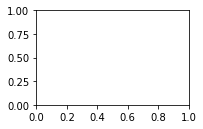

In [14]:
# Start timing
print("Computing posterior PDFs...")
lasttime = time.clock()


# Compute marginal PDFs of mass and age
logm, mpdf = cs.mpdf(0, phot, photerr, filters=filters)
logt, tpdf = cs.mpdf(1, phot, photerr, filters=filters)
logx, xpdf = cs.mpdf(2, phot, photerr, ngrid=1000, filters=filters)

# End timing
newtime = time.clock()
tottime = newtime - lasttime

# Print timing results
print("Computation time: {:f} seconds total, {:f} seconds / PDF".
      format(tottime, tottime/phot.shape[0]/2))

# Set up a plot window
plt.figure(1, figsize=(6,8))
plt.subplot(4,2,1)

In [15]:
# Compute the mean of the posterior PDFs returned by cluster_slug
mmean = np.sum(logm*mpdf*(logm[1]-logm[0]), axis=1)
tmean = np.sum(logt*tpdf*(logt[1]-logt[0]), axis=1)
xmean = np.sum(logx*xpdf*(logx[1]-logt[0]), axis=1)

# Compute the 25th, 50th, and 75th percentiles of the posterior PDFs
mpdfsum = np.cumsum(mpdf, axis=1)*(logm[1]-logm[0])
mpercentiles = np.array([
    logm[np.argmax(np.greater(mpdfsum, 0.1), axis=1)],
    logm[np.argmax(np.greater(mpdfsum, 0.5), axis=1)],
    logm[np.argmax(np.greater(mpdfsum, 0.9), axis=1)]])
tpdfsum = np.cumsum(tpdf, axis=1)*(logt[1]-logt[0])
tpercentiles = np.array([
    logt[np.argmax(np.greater(tpdfsum, 0.1), axis=1)],
    logt[np.argmax(np.greater(tpdfsum, 0.5), axis=1)],
    logt[np.argmax(np.greater(tpdfsum, 0.9), axis=1)]])
xpdfsum = np.cumsum(xpdf, axis=1)*(logx[1]-logx[0])
xpercentiles = np.array([
    logx[np.argmax(np.greater(xpdfsum, 0.1), axis=1)],
    logx[np.argmax(np.greater(xpdfsum, 0.5), axis=1)],
    logx[np.argmax(np.greater(xpdfsum, 0.9), axis=1)]])

In [16]:
# For each model, find the best match in the library for the 12 hand-picked clusters
matches, dist = cs.bestmatch(phot, filters=filters, nmatch=1)
dist = dist/np.sqrt(len(filters))

In [18]:
#Difference of the median of the Mass PDF & the previous mass apdata estimates in apdata

diffPDFmed_M_apdata=apdatagoodphot_2filts_logm-mpercentiles[1]
diffPDFmed_A_apdata=apdatagoodphot_2filts_logt-tpercentiles[1]
diffPDFmed_X_apdata=apdatagoodphot_2filts_logx-xpercentiles[1]

In [19]:
#Mass IQR
MassIQR=mpercentiles[2]-mpercentiles[0]
(MassIQR)

array([1.96053605, 1.44087589, 1.0156994 , ..., 1.93691513, 1.8896733 ,
       1.86605238])

In [20]:
#Age IQR
AgeIQR=tpercentiles[2]-tpercentiles[0]

In [21]:
#Av IQR
AvIQR=xpercentiles[2]-xpercentiles[0]

In [24]:
m31_Prop_PDF=Table([apdatagoodphot_2filts['ID'],apdatagoodphot_2filts['BEST_METHOD'],M31_Chi2Vals2['Chi2(2)'],
                    mpercentiles[0],mpercentiles[1],mpercentiles[2],MassIQR,diffPDFmed_M_apdata,tpercentiles[0],
                    tpercentiles[1],tpercentiles[2],AgeIQR,diffPDFmed_A_apdata,xpercentiles[0],xpercentiles[1],
                    xpercentiles[2],AvIQR,diffPDFmed_X_apdata],
                   names=('a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r'))

In [25]:
m31_Prop_PDF.rename_column('a', 'ID')
m31_Prop_PDF.rename_column('b', 'BEST_METHOD')
m31_Prop_PDF.rename_column('c', 'Chi_2(2)')
m31_Prop_PDF.rename_column('d', 'Mass_PDF_P25(2)')
m31_Prop_PDF.rename_column('e', 'Mass_PDF_Median(2)')
m31_Prop_PDF.rename_column('f', 'Mass_PDF_P75(2)')
m31_Prop_PDF.rename_column('g', 'MassIQR(2)')
m31_Prop_PDF.rename_column('h', 'SlugMass-m31BestMass(2)')
m31_Prop_PDF.rename_column('i', 'Age_PDF_P25(2)')
m31_Prop_PDF.rename_column('j', 'Age_PDF_Median(2)')
m31_Prop_PDF.rename_column('k', 'Age_PDF_P75(2)')
m31_Prop_PDF.rename_column('l', 'AgeIQR(2)')
m31_Prop_PDF.rename_column('m', 'SlugAge-m31BestAge(2)')
m31_Prop_PDF.rename_column('n', 'AV_PDF_P25(2)')
m31_Prop_PDF.rename_column('o', 'A_V_PDF_Median(2)')
m31_Prop_PDF.rename_column('p', 'A_V_PDF_P75(2)')
m31_Prop_PDF.rename_column('q', 'AvIQR(2)')
m31_Prop_PDF.rename_column('r', 'SlugAV-CMD_AV_Best(2)')
m31_Prop_PDF

ID,BEST_METHOD,Chi_2(2),Mass_PDF_P25(2),Mass_PDF_Median(2),Mass_PDF_P75(2),MassIQR(2),SlugMass-m31BestMass(2),Age_PDF_P25(2),Age_PDF_Median(2),Age_PDF_P75(2),AgeIQR(2),SlugAge-m31BestAge(2),AV_PDF_P25(2),A_V_PDF_Median(2),A_V_PDF_P75(2),AvIQR(2),SlugAV-CMD_AV_Best(2)
int32,bytes1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,I,1.3330784569926594e-05,2.1889762108832644,2.732257283706675,4.149512256289487,1.9605360454062226,1.3984666695403951,6.094488480920338,6.440945103735201,8.551180897243908,2.4566924163235697,2.5300126523072795,0.46158352238812,1.1535347956333997,1.9443362507708621,1.4827527283827422,-1.1535347956333997
2,M,3.542105481810372e-05,2.1417343784638376,2.5905317864483943,3.582610267256362,1.4408758887925242,1.3883443274432072,6.125984537539872,6.661417500071932,8.45669272738531,2.3307081898454376,1.7385821184583419,0.41215843144202857,1.054684613741217,1.8949111598247705,1.482752728382742,0.09531536241692518
3,I,5.730100847666283e-06,2.0944925460444104,2.448806289190113,3.110191943062092,1.0156993970176815,0.6413986649572259,6.188976650778938,6.850393839789129,8.204724274429045,2.0157476236501077,1.718182019280695,0.3627333404959372,0.8569842499568513,1.5983606141482223,1.235627273652285,-0.8569842499568513
4,I,0.00017348730626736097,2.165355294673551,2.637773618867821,3.8660612617729244,1.7007059670993736,1.4879111192913586,6.094488480920338,6.409449047115668,8.173228217809513,2.0787397368891742,2.565230899783746,0.46158352238812,1.104109704687308,1.8949111598247705,1.4333276374366506,-1.104109704687308
5,M,1.811175454186711e-05,2.118113462254124,2.519669037819254,3.322780188949513,1.2046667266953892,0.891583222388876,6.157480594159405,6.661417500071932,8.173228217809513,2.0157476236501077,1.7385821184583419,0.41215843144202857,1.0052595227951253,1.6972107960404053,1.2850523645983767,-0.5552595347160543
6,M,1.4551837587492784e-05,2.165355294673551,2.6613945350775348,3.9133030941923512,1.7479477995188004,1.1654713764062299,6.094488480920338,6.472441160354734,8.48818878400484,2.3937003030845023,2.027558839645266,0.41215843144202857,1.104109704687308,2.043186432663045,1.6310280012210163,-0.6041097046873081
7,M,2.3518865145535927e-06,2.118113462254124,2.4724272053998266,3.228296524110659,1.1101830618565351,0.6861993509966577,6.157480594159405,6.75590566993053,8.173228217809513,2.0157476236501077,1.4440941393346067,0.3627333404959372,0.9064093409029427,1.6477857050943139,1.2850523645983767,-0.45640935282387163
9,I,1.0488987860859004e-05,2.165355294673551,2.614152702658108,3.6770939320952163,1.5117386374216655,1.5541336208892553,6.094488480920338,6.377952990496135,7.7322834251360515,1.6377949442157131,2.4766116762519115,0.46158352238812,1.0052595227951253,1.6972107960404053,1.2356272736522853,-0.7552595227951253
11,I,9.963258102986174e-05,2.165355294673551,2.7794991161261025,3.7479566807243567,1.582601386050806,0.6339043949212608,6.188976650778938,7.606299198657919,8.866141463439238,2.6771648126603003,1.232641421764444,0.3627333404959372,1.104109704687308,2.1420366145552276,1.7793032740592905,-1.104109704687308


In [26]:
m31_Prop_PDF.write('/Volumes/My_Passport_for_Mac/M33_M31_LGCS_Files/M31-Andromeda/Prop_Tables/M31_Prop2filt1867cls.fits')